# Text Mining Project - Active Learning
#### Mamadou Mahdiou Diallo, Helmy El Rais, Dah Diarra
##### M2 Machine Learning for Data Science - Université de Paris


## Plan du notebook
1. Introduction
2. Méthodes
3. Implémentation
4. Données synthétiques
5. Données NG5
6. Conclusion

## Introduction

L'Active Learning est une méthode d'apprentissage dans laquelle on permet à l'apprenant de choisir les exemples dont il apprendra en vue d'accélérer l'apprentissage. Cette méthode a de nombreux avantages:
- elle accélère l'apprentissage en utilisant uniquement les données les plus importantes
- elle diminue la quantité de données labélisées dont on a besoin.
- dans les situations où l'obtention de données d'apprentissage est coûteux (expériences scientifiques, longues simulations, etc.) elle permet de réduire les coûts et la durée des projets.

## Méthodes
Dans un algorithme d'Active Learning, il existe deux rôles:
- L'apprenant: le modèle prédictif qu'on veut entraîner. C'est à lui de choisir les nouvelles données à labéliser.
- L'oracle: C'est l'entité qui connaît les classes des données d'apprentissage et peut les transmettre à l'apprenant à la demande. Il peut être un humain ou être simulé par un programme.

Il y a plusieurs types de problèmes (qu'on appelle scénarios) dans lesquels on peut utiliser l'Active Learning:
- L'apprenant peut générer de nouveaux exemples et demander à l'oracle de les labelliser (Membership Query Synthesis)
- Etant donné un flux d'examples, l'apprenant peut décider, pour chaque nouvel example s'il veut l'utiliser ou pas (Stream-based sampling)
- L'apprenant peut tester tous les examples et choisir ceux à partir desquels il veut apprendre (Pool-based sampling). C'est ce scénario que nous implémentons dans ce projet.

Après avoir défini le scénario, il faut aussi définir le critère de choix de nouveaux examples. La stratégie de choix est appelée "Query Strategy". Quelques stratégies existantes sont les suivantes: uncertainty sampling, query by committee, expected impact et density-weighted. 

En bref, query-by-committee entraîne plusieurs apprenants différents et les exemples sur lesquels les apprenants sont le plus en désaccord sont choisis pour l'apprentissage. La stratégie density-weighted utilise une mesure de la densité de l'information et choisi les exemples qui maximisent l'augmentation de celle-ci. La stratégie expected impact choisit les nouveaux exemples en fonction de l'apport qu'on espère obtenir du nouvel exemple; cela peut être la réduction du taux d'erreur, la réduction de la variance ou un changement significatif du modèle.

La stratégie la plus simple est Uncertainty Sampling. Dans cette stratégie, l'apprenant affecte des probabilités aux examples qui lui sont donnés et choisit ceux pour lesquels il est le plus "incertain". La mesure d'incertitude peut se faire de 3 manières différentes:
- Least Confidence sampling: (la plus petite confiance). Pour chacun des exemples, l'apprenant détermine la probabilité de la classe qui serait prédite. Les exemples qui ont la probabilité la plus basse sont choisis.
$$x^*_{LC} = \underset{x}{argmax}{1 - P_{\theta}(\hat{y}|x)} $$
où x est une donnée non labélisée, y est la classe prédite, $\theta$ représente l'hypothèse apprise par l'apprenant.

- Margin sampling: (la plus petite marge). Pour chacun des exemples, l'apprenant détermine la différence entre la classe la plus probable $\hat{y}_1$ et la seconde classe la plus probable $\hat{y}_2$. Les examples avec la plus petite différence sont choisis.
$$x^*_M = \underset{x}{argmax}{P_{\theta}(\hat{y}_1|x) - P_{\theta}(\hat{y}_2|x)} $$

- Entropy sampling: (l'entropie la plus élevée). Pour chacun des exemples, l'apprenant détermine l'entropie de la distribution des probabilités des classes. Les exemples pour lesquels l'entropie est la plus élevée sont choisis pour l'itération suivante.
$$x^*_H = \underset{x}{argmax}{-\underset{i}{\sum}{P_{\theta}(\hat{y}_i|x) log P_{\theta}(\hat{y}_i|x)}} $$

La stratégie implémentée dans ce projet est Uncertainty Sampling.

Le pseudocode de l'algorithme est comme suit:


**Input** : ensemble de données étiquetées **L**, et ensemble de données non étiquetées **U**

**Output** : ensemble de données étiquetées **L UNION U**

Tant que **U** non vide
1. Entraîner un classifieur **C** (par exemple, un simple classifieur bayesien naif) en utilisant **L**
2. Utiliser **C** pour prédire les données **U**
3. Sélectionner dans **U** *n* instances et former un ensemble **I** contenant ces instances
4. Demander à l’expert d’étiqueter **I**
5. Faire **L** = **L UNION I** et **U = U MOINS I**

## Implémentation

Pour im

![class](files/classes.png)

In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [23]:
from active_learning import ActiveLearner, Oracle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# animation
from matplotlib import animation
from celluloid import Camera

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# data
from sklearn.datasets import fetch_20newsgroups, make_blobs

from sklearn.base import clone

In [3]:
def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

In [17]:
def add_model_boundaries(ax, model, npts=100):
    # TODO: fix difference of color between data and grid
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    hx = (x_max - x_min)/npts
    hy = (y_max - y_min)/npts

    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
                         np.arange(y_min, y_max, hy))
    
    x = xx.ravel()
    y = yy.ravel()

    grid = np.c_[x, y]
    Z = model.predict(grid)
    
    probs = model.predict_proba(grid)
    probs = model.uncertainty_scorer(probs)
    
    colors = plt.cm.tab10(Z)
    colors[:, -1] = probs
    
    ax.scatter(x,y,c=colors,marker='.', s=6)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    return ax


def draw_choice(X, y, choice_order, ax, i, model, first=0):
    if i < 0:
        chosen = choice_order == -1
    else:
        chosen = choice_order == i
    
    choice = np.repeat('no', chosen.shape[0])
    choice = choice.astype('<U10')
    choice[(choice_order >= 0) & (choice_order <= i)] = 'yes'
    choice[choice_order == -1] = 'initial'
    
    pt_size = np.repeat('old', chosen.shape[0])
    pt_size[chosen] = 'new'
    pt_size = pd.Series(pt_size, name='selection time')
    
    choice = pd.Series(choice, name='chosen')
    target = pd.Series(y, name='class')
       
    sns.scatterplot(X[:,0], X[:,1],
                    ax=ax,
                    hue=target, palette='tab10',
                    size=pt_size,
                    size_order = ['new', 'old'],
                    sizes=(40, 80),
                    style=choice,
                    markers={'yes': 'o', 'no': 'X', 'initial': 's'},
                    legend='full' if i==first else None)
    
    if model is not None:
        add_model_boundaries(ax, model)
    
    if i == first:
        ax.legend(loc='center left', 
                  bbox_to_anchor=(1.01,.5))
    return ax

In [5]:
def animate_choices(X, y, choice_order, models, interval=200, first=0):
    fig = plt.figure(figsize=(10,5))
    
    # to avoid the legend being clipped
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.9]) # [left, bottom, width, height]
    
    camera = Camera(fig)
    chosen = np.zeros(choice_order.shape, dtype=bool)
    for it in range(-5, choice_order.max()+5):
        idx = min(it, len(models)-1)
        model = None if idx < 0 else models[idx]
        draw_choice(X, y, choice_order, ax, it, model, first=first)
        camera.snap()

    return camera.animate(interval=interval)

## Données synthétiques

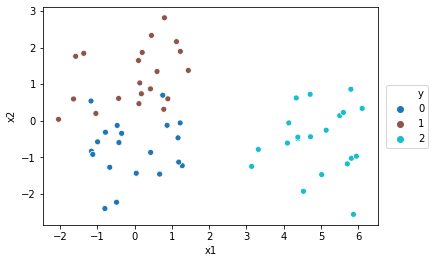

In [39]:
X, y = make_blobs(n_samples=60, centers=[(0,-1), (0,1), (5,0)])
data = pd.DataFrame({
    'x1': X[:, 0],
    'x2': X[:, 1],
    'y': y,
})

ax = sns.scatterplot(data.x1, data.x2,
                hue=data.y, palette='tab10',
                legend='full')
ax.legend(loc='center left', bbox_to_anchor=(1.01,.5))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

In [41]:
classifier = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class='auto'))
batch_size = 1
init_size = 3

In [42]:
clf = clone(classifier, safe=False)
lc_learner = ActiveLearner(clf, strategy='least_conf')
lc_oracle = Oracle(lc_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
lc_oracle.fit(X_train, y_train,
              batch_size=batch_size,
              init_size=init_size)

In [43]:
init_idx = lc_oracle.time_chosen_ == -1

In [44]:
clf = clone(classifier, safe=False)
margin_learner = ActiveLearner(clf, strategy='margin')
margin_oracle = Oracle(margin_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
margin_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

In [45]:
clf = clone(classifier, safe=False)
entropy_learner = ActiveLearner(clf, strategy='entropy')
entropy_oracle = Oracle(entropy_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
entropy_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

In [46]:
clf = clone(classifier, safe=False)
rand_learner = ActiveLearner(clf, strategy='random')
rand_oracle = Oracle(rand_learner, metrics=[precision_score, recall_score, f1_score], store_models=True)
rand_oracle.fit(X_train, y_train,
                  batch_size=batch_size,
                  init_labels_idx=init_idx)

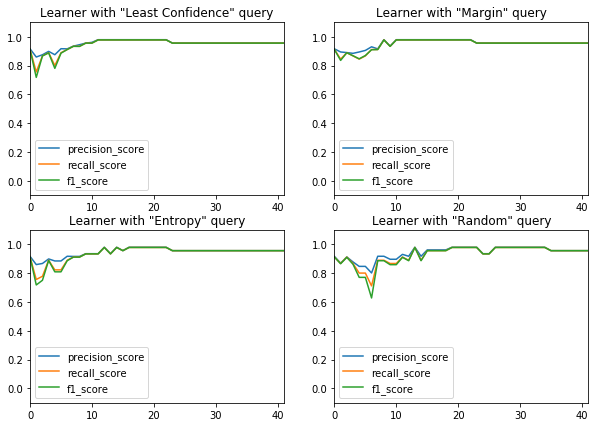

In [47]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(221)
lc_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Least Confidence" query')

ax = plt.subplot(222)
margin_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Margin" query')

ax = plt.subplot(223)
entropy_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Entropy" query')


ax = plt.subplot(224)
rand_oracle.performance_scores_.plot(ax=ax)
ax.set_ylim(-.1, 1.1)
ax.set_title('Learner with "Random" query');

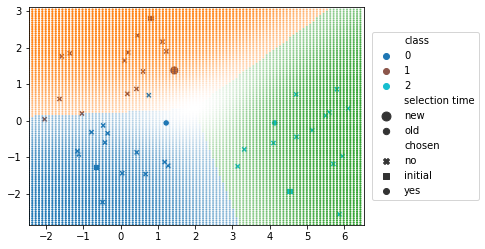

In [48]:
_, ax = plt.subplots()
it = 2
draw_choice(X_train, y_train, entropy_oracle.time_chosen_.copy(), ax, it, entropy_learner, first=it)

In [49]:
choice_order = lc_oracle.time_chosen_.copy()
models = lc_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [50]:
choice_order = margin_oracle.time_chosen_.copy()
models = margin_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [51]:
choice_order = entropy_oracle.time_chosen_.copy()
models = entropy_oracle.models_
# choice_order[choice_order >= 0] = choice_order[choice_order >= 0] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [52]:
choice_order = rand_oracle.time_chosen_.copy()
models = rand_oracle.models_
# choice_order[choice_order != -1] = choice_order[choice_order != -1] // 5 # reduce the number of frames
anim = animate_choices(X_train, y_train, choice_order, models, interval=500)
anim

In [53]:
def plot_choice_order(time_chosen, y, ax=None):
    choice_order = np.argsort(time_chosen)
    y = y[choice_order]
    labels = np.unique(y)
    classes = np.arange(labels.shape[0])
    class_mat = np.zeros((y.shape[0], classes.shape[0]), dtype=bool)
    for c in classes:
        class_mat[:, c] = y == labels[c]

    class_counts = class_mat.sum(axis=0)
    df_classes = pd.DataFrame(class_mat, columns=labels)

    percent_chosen = df_classes.cumsum(axis=0)/class_counts
    ax = percent_chosen.plot(cmap='tab10', ax=ax)
#     ax.legend(loc='center left',
#               bbox_to_anchor=(1.01,.5))
    return ax

In [ ]:
fig = plt.figure(figsize=(10,7))
fig.suptitle('Percentage of examples chosen for each class');

ax = plt.subplot(221)
ax = plot_choice_order(lc_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Least Confidence query')

ax = plt.subplot(222)
ax = plot_choice_order(margin_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Margin query')

ax = plt.subplot(223)
ax = plot_choice_order(entropy_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Entropy query')


ax = plt.subplot(224)
ax = plot_choice_order(rand_oracle.time_chosen_, y_train, ax=ax)
ax.set_title('Random query');

## Données NG5

In [ ]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

X_train, y_train = ng5_train.data, np.array(ng5_train.target)
X_test, y_test = ng5_test.data, np.array(ng5_test.target)

In [ ]:
tfidf = TfidfVectorizer().fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [ ]:
# clf = make_pipeline(TfidfVectorizer(), GaussianNB())
clf = GaussianNB()
learner = ActiveLearner(clf)
oracle = Oracle(learner, metrics=[precision_score, recall_score, f1_score])

In [ ]:
oracle.fit(X_train.toarray(), y_train, X_test.toarray(), y_test, batch_size=200, init_size=200)

In [ ]:
oracle.performance_scores_.plot()
# ax.set_title('Learner with "Least Confidence" query')
# ax = plt.subplot(222)
# margin_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Margin" query')
# ax = plt.subplot(223)
# entropy_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Entropy" query')
# ax = plt.subplot(224)
# rand_oracle.performance_scores_.plot(ax=ax)
# ax.set_title('Learner with "Random" query');

In [ ]:
plot_choice_order(oracle.time_chosen_, y_train)

## Conclusion